## Instructions on how to run this notebook

This LSTM model uses xtrain.txt and balancedtest.csv in the LUN dataset.

1. Make sure that the LUN dataset is in the folder "data/", and the folder is in the same hierarchy level as this notebook.
2. Download the GloVe embeddings folder [here](https://drive.google.com/drive/folders/1THNgTSNR8fQE15dweoU8s--yo00PvO_1)
3. Add the glove.6B folder so that it is in the same hierarchy level as this notebook.


In [1]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

import spacy

import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from imblearn.over_sampling import SMOTE
from collections import defaultdict

from scipy.sparse import issparse
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1, l2

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Embedding, GlobalMaxPooling1D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import one_hot
import os
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_df = pd.read_csv(f'data/xtrain.txt', names=('Verdict', 'Text'), delimiter='\t')
test_df = pd.read_csv(f'data/balancedtest.csv', names=('Verdict', 'Text'))

In [3]:
embedding_dim = 100
max_length = 250
embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.strip().split(' ')
    word = values[0]
    #print(word, values[1:])
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = vector
f.close()

def text_embedder(text:str, maxlen=max_length):
    text = text.lower()
    sequence = word_tokenize(text)
    sequence = [word.strip(string.punctuation) for word in sequence]
    word_embeddings = []
    for word in sequence:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None:
            #print(word)
            continue
        word_embeddings.append(embedding_vector)
        if len(word_embeddings) == maxlen:
            break
    if len(word_embeddings) < maxlen:
        word_embeddings = word_embeddings + [np.zeros(embedding_dim)]*(maxlen-len(word_embeddings))
    return word_embeddings

def sequencer_embedder(x_arr, max_len=max_length, embedding_dim=embedding_dim, embeddings_index=embeddings_index):
    x_arr_xs = x_arr.apply(text_embedder)
    esequences = np.zeros((x_arr_xs.shape[0], max_length, embedding_dim))
    for i, seq in enumerate(x_arr_xs):
        for j, evector in enumerate(seq):
            esequences[i, j, :] = evector
    return esequences

from sklearn.preprocessing import OneHotEncoder

# One-hot
def one_hot_encode(y_arr):
    encoder = OneHotEncoder(sparse_output=False)
    new_y_train = encoder.fit_transform(np.array(y_arr).reshape(-1,1))
    new_y_train = new_y_train.astype('float32')
    return new_y_train

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_dicts(train_df, test_df):
    text_train = train_df['Text']
    verd_train = train_df['Verdict']
    text_test = test_df['Text']
    verd_test = test_df['Verdict']

    train_dict = {}
    test_dict = {}

    tfidf = TfidfVectorizer(max_features=60000)
    tfidf.fit_transform(text_train)
    train_dict['tfidf'] = tfidf.transform(text_train).toarray()
    test_dict['tfidf'] = tfidf.transform(text_test).toarray()

    train_dict['lstm'] = sequencer_embedder(text_train)
    test_dict['lstm'] = sequencer_embedder(text_test)

    train_dict['y'] = one_hot_encode(verd_train)
    test_dict['y'] = one_hot_encode(verd_test)

    return train_dict, test_dict

In [5]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

        

from tensorflow.keras.optimizers import Adam
class RegularLSTMModel:
    def __init__(self, input_shapes, num_classes):
        self.input_shapes = input_shapes
        self.num_classes = num_classes

    def build(self):
        lstm_units = 160
        manual_dense_units = 96
        dropout_rate = 0.45
        learning_rate = 0.01

        text_input_shape = self.input_shapes['text']
        text_input = Input(shape=text_input_shape, name='text_input')
        lstm_layer = LSTM(lstm_units)(text_input)

        manual_input_shape = self.input_shapes['manual']
        manual_input = Input(shape=manual_input_shape, name='manual_input')
        manual_dense = Dense(manual_dense_units, activation='relu')(manual_input)

        concatenated = Concatenate()([lstm_layer, manual_dense])
        concatenated = Dropout(dropout_rate)(concatenated)

        output = Dense(self.num_classes, activation='softmax')(concatenated)

        model = Model(inputs=[text_input, manual_input], outputs=output)
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', F1Score()])

        return model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def build_train_test_model(train_dict, test_dict):

    train_features = [train_dict['lstm'], train_dict['tfidf']]
    train_labels = train_dict['y']
    val_features = [test_dict['lstm'], test_dict['tfidf']]
    val_labels = test_dict['y']
    input_shapes = {'text': train_dict['lstm'].shape[1:], 'manual': train_dict['tfidf'].shape[1:]}
    num_classes = train_labels.shape[1]

    model_builder = RegularLSTMModel(input_shapes, num_classes)
    model = model_builder.build()

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    history = model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels), callbacks=[stop_early], batch_size=64)

    val_loss, val_accuracy, val_f1_score = model.evaluate(val_features, val_labels)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation F1 Score: {val_f1_score}')

    predictions = model.predict(val_features)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(val_labels, axis=1)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Satire', 'Hoax', 'Propaganda', 'Reliable News'])
    disp.plot()

    class_names = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:")
    print(report)

    return model, history, val_f1_score, val_accuracy

Epoch 1/10
250/250 [==============================] - 8s 21ms/step - loss: 0.2680 - accuracy: 0.9079 - f1_score: 0.9054 - val_loss: 0.8029 - val_accuracy: 0.7493 - val_f1_score: 0.7508
Epoch 2/10
250/250 [==============================] - 4s 17ms/step - loss: 0.0207 - accuracy: 0.9945 - f1_score: 0.9944 - val_loss: 0.9966 - val_accuracy: 0.7427 - val_f1_score: 0.7415
Epoch 3/10
94/94 [==============================] - 1s 7ms/step - loss: 1.1606 - accuracy: 0.7410 - f1_score: 0.7419
Validation Loss: 1.1605677604675293
Validation Accuracy: 0.7409999966621399
Validation F1 Score: 0.7418866157531738
94/94 [==============================] - 1s 6ms/step
Classification Report:
               precision    recall  f1-score   support

       Satire       0.86      0.77      0.81       750
         Hoax       0.78      0.50      0.61       750
   Propaganda       0.63      0.75      0.68       750
Reliable News       0.74      0.95      0.83       750

     accuracy                           0.74

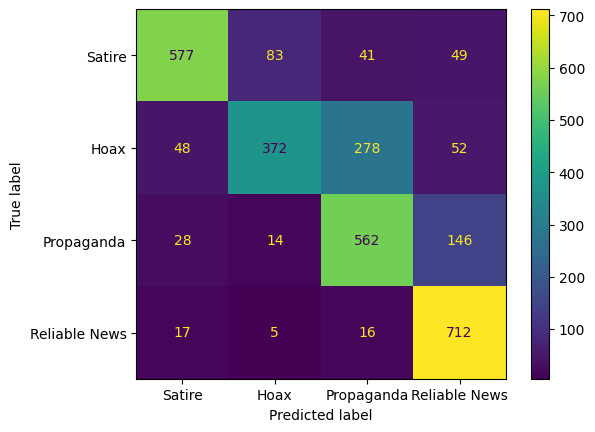

In [7]:
train_dict_regular, test_dict_regular = create_dicts(train_df, test_df)
m_r, h_r, f1_r, a_r = build_train_test_model(train_dict_regular, test_dict_regular)